In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

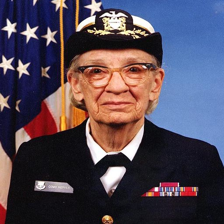

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 583ms/step


(1, 1001)

In [7]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

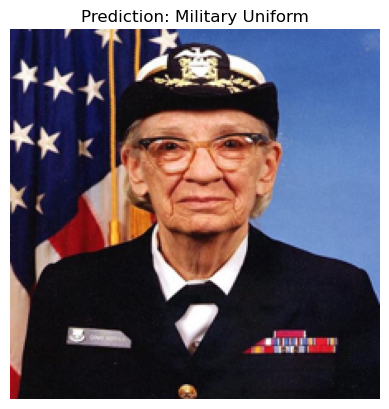

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [10]:
#transfer learning begins
import pathlib

data_root = pathlib.Path('./PlantVillage')

class_dirs = ['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'mosaic_virus', 'septoria_leaf_spot', 'target_spot', 'two_spotted_spider_mites', 'yellowleaf_curl_virus']

data_paths = [data_root / class_name for class_name in class_dirs]

for path in data_paths:
    assert path.exists(), f"Could not find directory at {path}"

In [11]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.


In [12]:
class_names = np.array(train_ds.class_names)
print(class_names)

['bacterial_spot' 'early_blight' 'healthy' 'late_blight' 'leaf_mold'
 'mosaic_virus' 'septoria_leaf_spot' 'target_spot'
 'two_spotted_spider_mites' 'yellowleaf_curl_virus']


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [16]:
# result_batch = classifier.predict(train_ds) # results in the process halting in the middle

try:
    result_batch = classifier.predict(train_ds, batch_size=8, verbose=1)
except tf.errors.ResourceExhaustedError:
    print("Out of memory error - try reducing batch size")
except Exception as e:
    print(f"Error during prediction: {str(e)}")

401/401 [==============================] - 9s 22ms/step


In [17]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['velvet', 'African chameleon', 'head cabbage', ..., 'handkerchief',
       'head cabbage', 'head cabbage'], dtype='<U30')

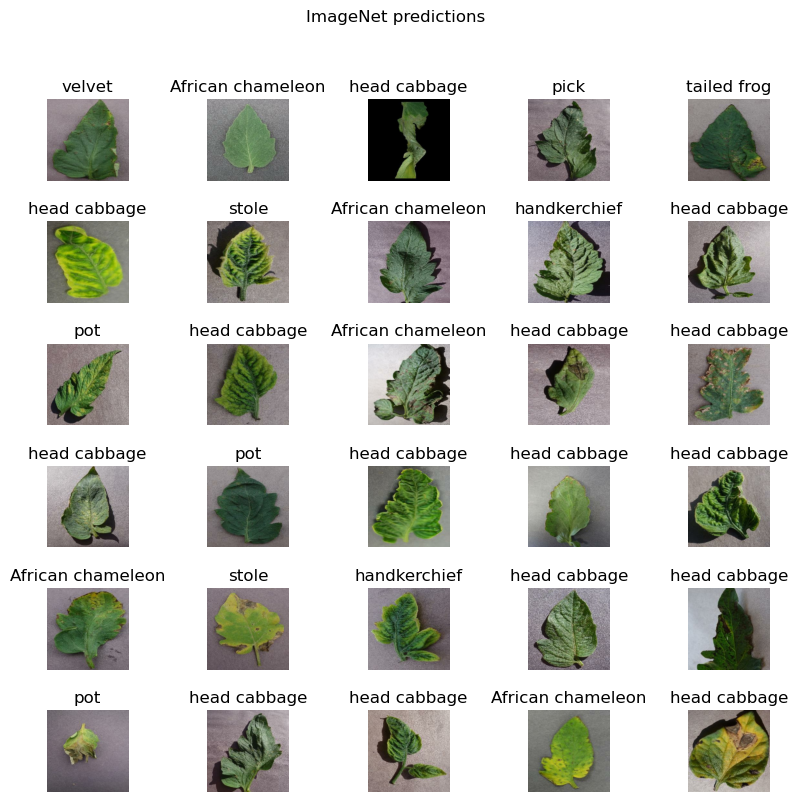

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [19]:
#headless model begins now

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 10])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [27]:
NUM_EPOCHS = 50

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/50
401/401 [==============================] - 16s 36ms/step - loss: 0.7067 - acc: 0.7830 - val_loss: 0.4352 - val_acc: 0.8679
Epoch 2/50
401/401 [==============================] - 13s 33ms/step - loss: 0.3598 - acc: 0.8891 - val_loss: 0.3542 - val_acc: 0.8885
Epoch 3/50
401/401 [==============================] - 13s 32ms/step - loss: 0.2836 - acc: 0.9129 - val_loss: 0.3214 - val_acc: 0.8991
Epoch 4/50
401/401 [==============================] - 13s 32ms/step - loss: 0.2404 - acc: 0.9262 - val_loss: 0.3030 - val_acc: 0.9032
Epoch 5/50
401/401 [==============================] - 13s 32ms/step - loss: 0.2103 - acc: 0.9366 - val_loss: 0.2909 - val_acc: 0.9066
Epoch 6/50
401/401 [==============================] - 13s 32ms/step - loss: 0.1873 - acc: 0.9455 - val_loss: 0.2823 - val_acc: 0.9076
Epoch 7/50
401/401 [==============================] - 13s 32ms/step - loss: 0.1687 - acc: 0.9530 - val_loss: 0.2761 - val_acc: 0.9069
Epoch 8/50
401/401 [==============================] - 13s 32ms

In [28]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 520ms/step
['bacterial_spot' 'healthy' 'late_blight' 'target_spot' 'bacterial_spot'
 'yellowleaf_curl_virus' 'yellowleaf_curl_virus' 'target_spot'
 'target_spot' 'two_spotted_spider_mites' 'leaf_mold'
 'yellowleaf_curl_virus' 'early_blight' 'early_blight' 'bacterial_spot'
 'two_spotted_spider_mites' 'bacterial_spot' 'yellowleaf_curl_virus'
 'bacterial_spot' 'yellowleaf_curl_virus' 'bacterial_spot'
 'septoria_leaf_spot' 'yellowleaf_curl_virus' 'healthy' 'early_blight'
 'late_blight' 'target_spot' 'yellowleaf_curl_virus'
 'yellowleaf_curl_virus' 'early_blight' 'healthy' 'mosaic_virus']


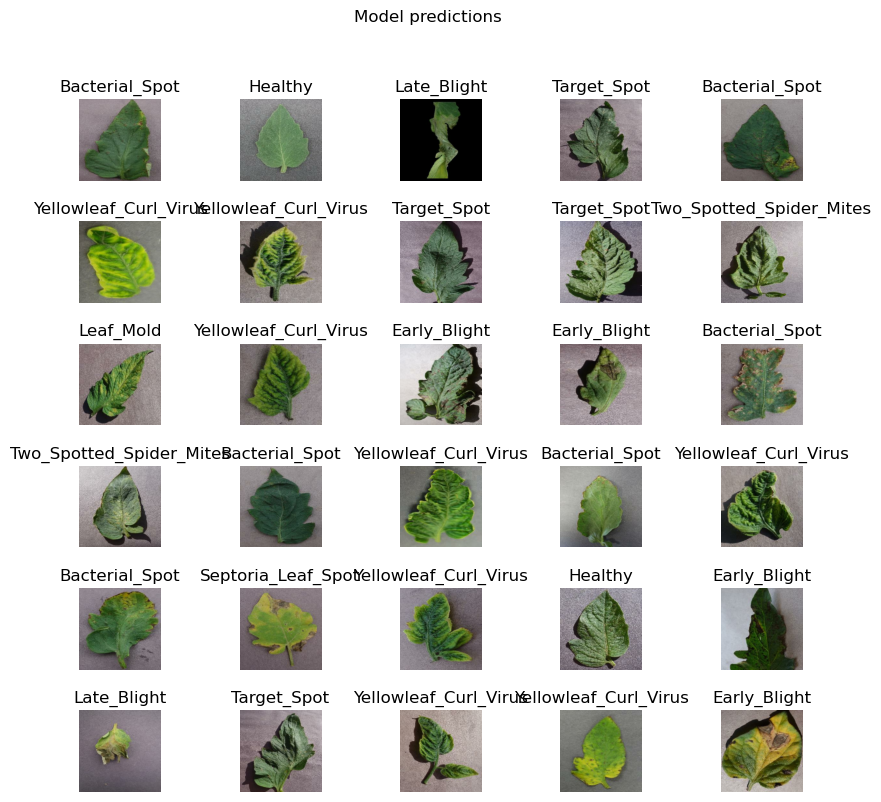

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [40]:
# model.save('tomato.h5')

In [36]:
t = time.time()

export_path = "E:/LEAF-NON_LEAF/tomato_disease_classifier/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: E:/LEAF-NON_LEAF/tomato_disease_classifier/1738057563\assets


INFO:tensorflow:Assets written to: E:/LEAF-NON_LEAF/tomato_disease_classifier/1738057563\assets


'E:/LEAF-NON_LEAF/tomato_disease_classifier/1738057563'

In [37]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 254ms/step


['bacterial_spot' 'healthy' 'late_blight' 'target_spot' 'bacterial_spot'
 'yellowleaf_curl_virus' 'yellowleaf_curl_virus' 'target_spot'
 'target_spot' 'two_spotted_spider_mites' 'leaf_mold'
 'yellowleaf_curl_virus' 'early_blight' 'early_blight' 'bacterial_spot'
 'two_spotted_spider_mites' 'bacterial_spot' 'yellowleaf_curl_virus'
 'bacterial_spot' 'yellowleaf_curl_virus' 'bacterial_spot'
 'septoria_leaf_spot' 'yellowleaf_curl_virus' 'healthy' 'early_blight'
 'late_blight' 'target_spot' 'yellowleaf_curl_virus'
 'yellowleaf_curl_virus' 'early_blight' 'healthy' 'mosaic_virus']


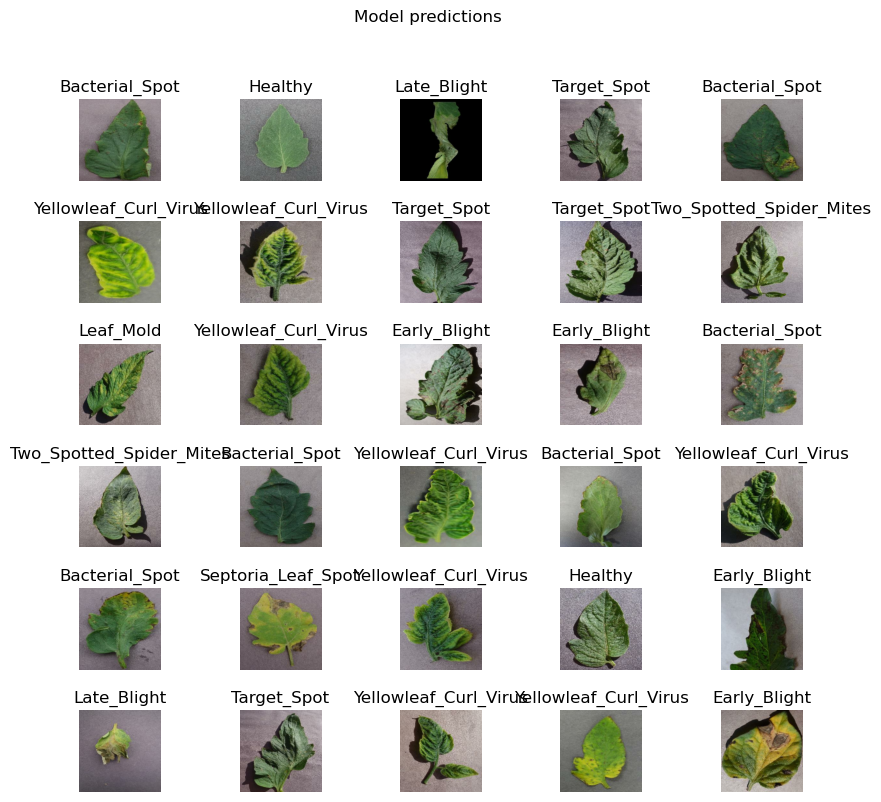

In [38]:
abs(reloaded_result_batch - result_batch).max()

reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [39]:
import time
import os

# Get the current time as a unique identifier
t = time.time()

# Get the current working directory
current_directory = os.getcwd()

# Define the export path using the current directory
export_path = os.path.join(current_directory, "saved_models", str(int(t)))

# Create the directory if it doesn't exist
os.makedirs(export_path, exist_ok=True)

# Save the model
model.save(export_path)

# Output the export path
export_path


INFO:tensorflow:Assets written to: E:\LEAF-NON_LEAF\tomato_disease_classifier\saved_models\1738057572\assets


INFO:tensorflow:Assets written to: E:\LEAF-NON_LEAF\tomato_disease_classifier\saved_models\1738057572\assets


'E:\\LEAF-NON_LEAF\\tomato_disease_classifier\\saved_models\\1738057572'

In [7]:
import tensorflow as tf
from PIL import Image
import numpy as np
class_names = np.array(['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'mosaic_virus', 'septoria_leaf_spot', 'target_spot', 'two_spotted_spider_mites', 'yellowleaf_curl_virus'])
# class_names = np.array(['leaf', 'non_leaf'])

In [5]:

def load_and_preprocess_image(image_path, target_size=(224, 224)):  # Adjust target_size to match your model's input size
    # Load the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=target_size
    )
    
    # Convert to array and add batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    # Normalize pixel values
    img_array = img_array / 255.0  # Scale pixels between 0 and 1
    
    return img_array

In [43]:
# Load the model
reloaded = tf.keras.models.load_model("./saved_models/saved")

reloaded.save("E:/LEAF-NON_LEAF/tomato_disease_classifier/tomato.h5", save_format='h5')

In [45]:
# Preprocess the image
image_array = load_and_preprocess_image("photo.jpg")

# Make prediction
predicted = reloaded.predict(image_array)
predicted_id = tf.math.argmax(predicted, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 329ms/step
yellowleaf_curl_virus


C:\Users\SUDIP 001\AppData\Local\Temp\ipykernel_15880\1652076298.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  predicted_label_batch = class_names[predicted_id]


In [46]:
path = './tomato.h5'

my_reloaded_model = tf.keras.models.load_model(
       (path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [47]:
model = my_reloaded_model

In [48]:
#confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# model = load_model('tomato.h5')

test_dir = 'PlantVillage'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Set your image dimensions
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Important: Do not shuffle for confusion matrix
)

Found 16011 images belonging to 10 classes.


In [49]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

16011/16011 [==============================] - 83s 5ms/step


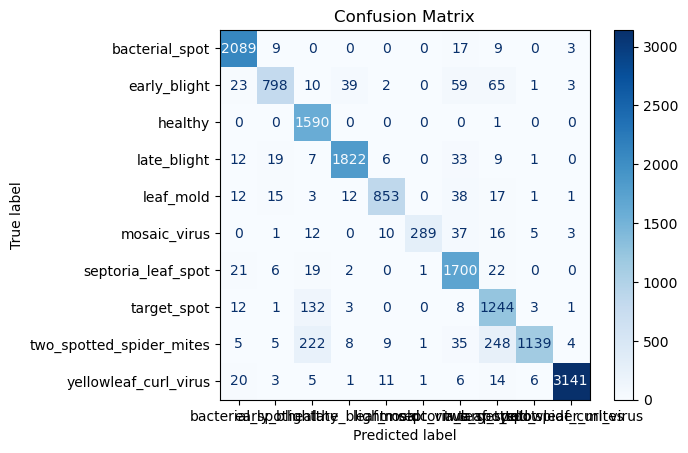

In [50]:
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

path = './tomato.h5'

model = tf.keras.models.load_model(
       (path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [8]:
# Preprocess the image
image_array = load_and_preprocess_image("photo.jpg")

# Make prediction
predicted = model.predict(image_array)
predicted_id = tf.math.argmax(predicted, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 18ms/step
yellowleaf_curl_virus


C:\Users\SUDIP 001\AppData\Local\Temp\ipykernel_9480\1389155956.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  predicted_label_batch = class_names[predicted_id]


In [20]:
probabilities

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9.7550366e-20, 9.8543450e-26, 7.5562494e-34, 2.5853237e-25,
       3.6521543e-14, 4.2073142e-23, 5.5813524e-26, 1.2473772e-29,
       1.4278631e-21, 1.0000000e+00], dtype=float32)>

In [23]:
final = class_names[tf.math.argmax(probabilities, axis=-1)]
print(final)
print(np.max(probabilities))

yellowleaf_curl_virus
